In [220]:
# Работа с табличными данными

import pandas as pd
import numpy as np


# Визуализация

import plotly.express as px
import plotly.io as pio
pio.templates.default = 'plotly_dark'
pio.renderers.default = 'notebook'
from motorica.emg8.utils import fig_montage # кастомная функция визуализации


# Пайплайн

# константы
from motorica.emg8.constants import *
# чтение данных и разметка по фактическим жестам
from motorica.emg8.pipeline import read_emg8
from motorica.emg8.markers import BasePeakMarker #, TransMarker
# создание экземпляра пайплайна
# from motorica.emg8.pipeline import create_grad_logreg_pipeline


# Метрики
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

# Модель
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.utils import to_categorical

# Для вывода докстрингов с форматированием markdown
from IPython.display import Markdown as md

# Работа с файлами
import os

# Для оценки скорости инференса
from time import time

In [222]:
""" # ----------------------------------------------------------------------------------------------
# ПАРАМЕТРЫ ЧТЕНИЯ ИСХОДНЫХ ДАННЫХ И РАЗМЕТКИ

DATA_DIR = 'data/new'

N_OMG_CH = 16         # количество каналов OMG-датчиков
OMG_COL_PRFX = 'omg'  # префикс в названиях столбцов датафрейма, соответствующих OMG-датчикам
STATE_COL = 'state'   # столбец с названием жеста, соответствующего команде
CMD_COL = 'id'        # столбец с меткой команды на выполнение жеста
TS_COL = 'ts'         # столбец метки времени

NOGO_STATE = 'Neutral'      # статус, обозначающий нейтральный жест
BASELINE_STATE = 'Baseline' # доп. служебный статус в начале монтажа
FINISH_STATE   = 'Finish'   # доп. служебный статус в конце монтажа

# Список с названиями всех столбцов OMG
OMG_CH = [OMG_COL_PRFX + str(i) for i in range(N_OMG_CH)]

# Новые столбцы:
SYNC_COL = 'sample'   # порядковый номер размеченного жеста
GROUP_COL = 'group'   # новый группы (цикла протокола)
TARGET = 'act_label'  # таргет (метка фактически выполняемого жеста)

timesteps = 3       # Количество последовательностей
# ---------------------------------------------------------------------------------------------- """

" # ----------------------------------------------------------------------------------------------\n# ПАРАМЕТРЫ ЧТЕНИЯ ИСХОДНЫХ ДАННЫХ И РАЗМЕТКИ\n\nDATA_DIR = 'data/new'\n\nN_OMG_CH = 16         # количество каналов OMG-датчиков\nOMG_COL_PRFX = 'omg'  # префикс в названиях столбцов датафрейма, соответствующих OMG-датчикам\nSTATE_COL = 'state'   # столбец с названием жеста, соответствующего команде\nCMD_COL = 'id'        # столбец с меткой команды на выполнение жеста\nTS_COL = 'ts'         # столбец метки времени\n\nNOGO_STATE = 'Neutral'      # статус, обозначающий нейтральный жест\nBASELINE_STATE = 'Baseline' # доп. служебный статус в начале монтажа\nFINISH_STATE   = 'Finish'   # доп. служебный статус в конце монтажа\n\n# Список с названиями всех столбцов OMG\nOMG_CH = [OMG_COL_PRFX + str(i) for i in range(N_OMG_CH)]\n\n# Новые столбцы:\nSYNC_COL = 'sample'   # порядковый номер размеченного жеста\nGROUP_COL = 'group'   # новый группы (цикла протокола)\nTARGET = 'act_label'  # таргет 

In [223]:
# Папка с файлами данных
DATA_DIR = 'data/plt_mb/all'

montages = sorted(filter(lambda f: f.endswith('.emg8'), os.listdir(DATA_DIR)))
montages

['2024-12-12_20-23-37.emg8',
 '2024-12-12_20-29-14.emg8',
 '2024-12-12_20-34-24.emg8',
 '2024-12-13_19-48-48.emg8',
 '2024-12-13_19-53-58.emg8',
 '2024-12-13_20-00-16.emg8',
 '2024-12-15_14-56-56.emg8',
 '2024-12-15_15-02-08.emg8',
 '2024-12-15_15-06-56.emg8']

In [224]:
montage = montages[-1]
gestures_raw = pd.read_csv(os.path.join(DATA_DIR, montage), sep=' ')
fig_montage(
    gestures_raw[OMG_CH], y_cmd=gestures_raw['id'], 
    title=f"<i>{montage}</i> – исходные данные"
).show()

In [225]:
n_holdout_groups = 1 # отложенная выборка - последний цикл протокола

marker = BasePeakMarker()

X_train, X_test, y_train, y_test, gestures, cv_groups = read_emg8(
    montage, dir=DATA_DIR,
    n_holdout_groups=n_holdout_groups,
    marker=marker
)

last_train_idx = gestures[GROUP_COL].drop_duplicates().index[-n_holdout_groups] - 1

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

state_id = gestures[['id', 'state']].drop_duplicates()
GESTURES = state_id['state'] + ' ' + state_id['id'].astype(str)
display(GESTURES)

display

fig_montage(
    gestures[OMG_CH], 
    y_cmd=gestures[CMD_COL], 
    y_act=gestures[TARGET],
    protocol_cycle=gestures[GROUP_COL],
    # grad2=marker.peaks_grad2 / 2,
    # grad2_neg=marker.peaks_grad2_neg / 2,
    # std1=marker.peaks_std1 / 2,
    # std1_neg=marker.peaks_std1_neg / 2,
    title=f"<i>{montage}</i> – разметка по фактическим границам жестов"
).show() 

X_train shape: (4356, 16)
y_train shape: (4356,)
X_test shape: (1144, 16)
y_test shape: (1144,)


125          Neutral 0
225     ThumbFingers 1
375            Close 2
525             Open 3
675            Pinch 4
825       Indication 5
975       Wrist_Flex 6
1125    Wrist_Extend 7
dtype: object

In [226]:
file_paths = sorted(filter(lambda f: f.endswith('.emg8'), os.listdir(DATA_DIR)))
file_paths

['2024-12-12_20-23-37.emg8',
 '2024-12-12_20-29-14.emg8',
 '2024-12-12_20-34-24.emg8',
 '2024-12-13_19-48-48.emg8',
 '2024-12-13_19-53-58.emg8',
 '2024-12-13_20-00-16.emg8',
 '2024-12-15_14-56-56.emg8',
 '2024-12-15_15-02-08.emg8',
 '2024-12-15_15-06-56.emg8']

# Эксперимет с данными с дополнительными классами переходов

In [227]:
""" trans_marker = TransMarker(use_peaks='std', bounds_shift=0)
X_train_trans, X_test_trans, y_train_trans, y_test_trans, gestures_trans, cv_groups_trans = read_emg8(
    montage, dir=DATA_DIR,
    n_holdout_groups=1,
    marker=trans_marker
)

X_train_list, X_test_list, y_train_list, y_test_list, gestures_train, gestures_test, cv_groups_list = [], [], [], [], [], [], []

for file_path in file_paths:  # Используем все файлы, чтобы улучшить вариативность модели, тестирование будет на каждом кусочке от этих файлов
        X_train, X_test, y_train, y_test, data_origin, groups = read_emg8(file_path, dir=DATA_DIR, n_holdout_groups=1, marker=trans_marker)
        X_train_list.append(X_train)
        X_test_list.append(X_test)

        y_train_list.append(y_train)
        y_test_list.append(y_test)

        cv_groups_list.append(groups)
        

# Объединение данных для обучения
X_train_combined = np.vstack(X_train_list)
X_test_combined = np.vstack(X_test_list)
y_train_combined = np.concatenate(y_train_list)
y_test_combined = np.concatenate(y_test_list)

cv_groups_combined = np.concatenate(cv_groups_list) """

" trans_marker = TransMarker(use_peaks='std', bounds_shift=0)\nX_train_trans, X_test_trans, y_train_trans, y_test_trans, gestures_trans, cv_groups_trans = read_emg8(\n    montage, dir=DATA_DIR,\n    n_holdout_groups=1,\n    marker=trans_marker\n)\n\nX_train_list, X_test_list, y_train_list, y_test_list, gestures_train, gestures_test, cv_groups_list = [], [], [], [], [], [], []\n\nfor file_path in file_paths:  # Используем все файлы, чтобы улучшить вариативность модели, тестирование будет на каждом кусочке от этих файлов\n        X_train, X_test, y_train, y_test, data_origin, groups = read_emg8(file_path, dir=DATA_DIR, n_holdout_groups=1, marker=trans_marker)\n        X_train_list.append(X_train)\n        X_test_list.append(X_test)\n\n        y_train_list.append(y_train)\n        y_test_list.append(y_test)\n\n        cv_groups_list.append(groups)\n        \n\n# Объединение данных для обучения\nX_train_combined = np.vstack(X_train_list)\nX_test_combined = np.vstack(X_test_list)\ny_train_c

# Сборка (конкатенация данных из разных файлов)

In [228]:
marker = BasePeakMarker()

X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

for file_path in file_paths:  # Используем все файлы, чтобы улучшить вариативность модели, тестирование будет на каждом кусочке от этих файлов
        X_train, X_test, y_train, y_test, data_origin, groups = read_emg8(file_path, dir=DATA_DIR, n_holdout_groups=1, marker=marker)
        
        X_train_list.append(X_train)
        X_test_list.append(X_test)
        y_train_list.append(y_train)
        y_test_list.append(y_test)

# Объединение данных для обучения
X_train_combined = np.vstack(X_train_list)
X_test_combined = np.vstack(X_test_list)
y_train_combined = np.concatenate(y_train_list)
y_test_combined = np.concatenate(y_test_list)

# Нормализация MinMax

In [229]:
# Нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1000))
X_train_combined = scaler.fit_transform(X_train_combined)
X_test_combined = scaler.transform(X_test_combined)

In [211]:
X_test_combined

array([[903.20413906, 858.99712902, 514.22373426, ..., 733.81094616,
        721.06714122, 841.63288553],
       [904.39196979, 861.446749  , 516.07788009, ..., 732.04125939,
        720.00061714, 846.31419267],
       [910.32273192, 872.92462752, 524.55674482, ..., 729.47752273,
        709.73788623, 868.42724577],
       ...,
       [995.85785532, 843.49278351, 572.35791676, ..., 345.31002174,
        589.89249219, 587.69662991],
       [995.91927178, 841.62764568, 571.49770245, ..., 341.38809484,
        586.97297774, 585.9047227 ],
       [995.85359874, 838.1732679 , 571.24393799, ..., 336.87987976,
        586.35817866, 586.90031078]])

# Создание последовательностей для подачи в модель

In [78]:
def create_sequences(X, y, timesteps=3):
    # Создание последовательностей
    X_sequences, y_sequences = [], []
    for i in range(len(X) - timesteps):
        X_sequences.append(X[i:i+timesteps])
        y_sequences.append(y[i+timesteps])

    return np.array(X_sequences), np.array(y_sequences)

# Преобразование в numpy массивы
X_sequences_train, y_sequences_train = create_sequences(X_train_combined, y_train_combined, timesteps)
X_sequences_test, y_sequences_test = create_sequences(X_test_combined, y_test_combined, timesteps)

# Приведение к формату (samples, timesteps, features)
X_sequences_train = X_sequences_train.reshape((X_sequences_train.shape[0], timesteps, X_sequences_train.shape[2]))
X_sequences_test = X_sequences_test.reshape((X_sequences_test.shape[0], timesteps, X_sequences_test.shape[2]))
print("X_sequences_train shape:", X_sequences_train.shape)
print("X_sequences_test shape:", X_sequences_test.shape)
print("y_sequences_train shape:", y_sequences_train.shape)
print("y_sequences_test shape:", y_sequences_test.shape)

X_sequences_train shape: (39210, 3, 16)
X_sequences_test shape: (10284, 3, 16)
y_sequences_train shape: (39210,)
y_sequences_test shape: (10284,)


In [79]:
# Преобразование меток в one-hot encoding
y_sequences_train_encoded = to_categorical(y_sequences_train)
y_sequences_test_encoded = to_categorical(y_sequences_test)
num_classes = to_categorical(y_sequences_test).shape[1]
print("y_sequences_train shape:", y_sequences_train_encoded.shape)
print("y_sequences_test shape:", y_sequences_test_encoded.shape)

y_sequences_train shape: (39210, 8)
y_sequences_test shape: (10284, 8)


# Создание LSTM 

In [44]:
import optuna
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.metrics import classification_report
import numpy as np

# Функция для создания модели LSTM
def create_lstm_model(input_shape, n_units=32, dropout_rate=0.2, learning_rate=0.001, use_bidirectional=False, use_gru=False):
    model = Sequential()
    if use_bidirectional:
        model.add(Bidirectional(LSTM(32, input_shape=input_shape, return_sequences=True, kernel_regularizer=l2(0.01))))
    elif use_gru:
        model.add(GRU(32, input_shape=input_shape, return_sequences=True, kernel_regularizer=l2(0.01)))
    else:
        model.add(LSTM(32, input_shape=input_shape, return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(Dropout(dropout_rate))
    if use_bidirectional:
        model.add(Bidirectional(LSTM(n_units, return_sequences=False, kernel_regularizer=l2(0.01))))
    elif use_gru:
        model.add(GRU(n_units, return_sequences=False, kernel_regularizer=l2(0.01)))
    else:
        model.add(LSTM(n_units, return_sequences=False, kernel_regularizer=l2(0.01)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(y_sequences_train_encoded.shape[1], activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Оптимизация и подбор гиперпараметров

In [45]:
# Функция для оптимизации гиперпараметров
def optimize_lstm(X_train_combined, y_train_combined, X_val, y_val):
    def objective(trial):
        timesteps = trial.suggest_int('timesteps', 1, 4)
        n_units = trial.suggest_int('n_units', 32, 128)
        dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.2)
        learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
        use_bidirectional = trial.suggest_categorical('use_bidirectional', [True, False])
        use_gru = trial.suggest_categorical('use_gru', [True, False])

        # Создание последовательностей с новым значением timesteps
        X_train_seq, y_train_seq = create_sequences(X_train_combined, y_train_combined, timesteps)
        X_val_seq, y_val_seq = create_sequences(X_val, y_val, timesteps)

        # Приведение к формату (samples, timesteps, features)
        X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], timesteps, X_train_seq.shape[2]))
        X_val_seq = X_val_seq.reshape((X_val_seq.shape[0], timesteps, X_val_seq.shape[2]))
        y_train_seq = to_categorical(y_train_seq, num_classes=num_classes)
        y_val_seq = to_categorical(y_val_seq, num_classes=num_classes)

        model = create_lstm_model((timesteps, X_train_seq.shape[2]), n_units, dropout_rate, learning_rate, use_bidirectional, use_gru)
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), epochs=25, batch_size=64, callbacks=[early_stopping], verbose=0)
        val_loss, val_accuracy = model.evaluate(X_val_seq, y_val_seq, verbose=0)
        return val_accuracy

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)
    return study.best_params

In [46]:
best_params = optimize_lstm(X_train_combined, y_train_combined, X_test_combined, y_test_combined)

# Использование лучших гиперпараметров для дальнейшего обучения модели
timesteps = best_params.pop('timesteps')
n_units = best_params['n_units']
dropout_rate = best_params['dropout_rate']
learning_rate = best_params['learning_rate']
use_bidirectional = best_params['use_bidirectional']
use_gru = best_params['use_gru']

C:\Users\User\AppData\Local\Temp\ipykernel_9660\2355893168.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



# Подготовка данных с учётом лучших timesteps

In [80]:
# Преобразование в numpy массивы
X_sequences_train, y_sequences_train = create_sequences(X_train_combined, y_train_combined, timesteps)
X_sequences_test, y_sequences_test = create_sequences(X_test_combined, y_test_combined, timesteps)

# Приведение к формату (samples, timesteps, features)
X_sequences_train = X_sequences_train.reshape((X_sequences_train.shape[0], timesteps, X_sequences_train.shape[2]))
X_sequences_test = X_sequences_test.reshape((X_sequences_test.shape[0], timesteps, X_sequences_test.shape[2]))

y_sequences_train_encoded = to_categorical(y_sequences_train, num_classes=num_classes)
y_sequences_test_encoded = to_categorical(y_sequences_test, num_classes=num_classes)
print("y_sequences_train shape:", y_sequences_train_encoded.shape)
print("y_sequences_test shape:", y_sequences_test_encoded.shape)

y_sequences_train shape: (39210, 8)
y_sequences_test shape: (10284, 8)


In [50]:
# Построение модели с лучшими гиперпараметрами
model = create_lstm_model((timesteps, X_sequences_train.shape[2]), n_units, dropout_rate, learning_rate, use_bidirectional, use_gru)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_sequences_train, y_sequences_train_encoded, validation_data=(X_sequences_test, y_sequences_test_encoded), epochs=100, batch_size=64, callbacks=[early_stopping], verbose=1)

model.save('model/lstm_gestures_model.h5')

Epoch 1/100
614/614 [==============================] - 13s 7ms/step - loss: 2.9985 - accuracy: 0.6209 - val_loss: 1.8731 - val_accuracy: 0.6574
Epoch 2/100
614/614 [==============================] - 3s 4ms/step - loss: 1.6503 - accuracy: 0.6660 - val_loss: 1.4123 - val_accuracy: 0.7039
Epoch 3/100
614/614 [==============================] - 3s 4ms/step - loss: 1.3649 - accuracy: 0.7192 - val_loss: 1.2310 - val_accuracy: 0.7605
Epoch 4/100
614/614 [==============================] - 3s 4ms/step - loss: 1.2362 - accuracy: 0.7469 - val_loss: 1.1374 - val_accuracy: 0.7695
Epoch 5/100
614/614 [==============================] - 3s 4ms/step - loss: 1.1569 - accuracy: 0.7622 - val_loss: 1.0717 - val_accuracy: 0.7795
Epoch 6/100
614/614 [==============================] - 3s 5ms/step - loss: 1.1084 - accuracy: 0.7712 - val_loss: 1.0317 - val_accuracy: 0.7979
Epoch 7/100
614/614 [==============================] - 3s 4ms/step - loss: 1.0675 - accuracy: 0.7815 - val_loss: 0.9933 - val_accuracy: 0.809

# Визуализация обучения модели

C:\Users\User\AppData\Local\Temp\ipykernel_9660\974158325.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\User\AppData\Local\Temp\ipykernel_9660\974158325.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

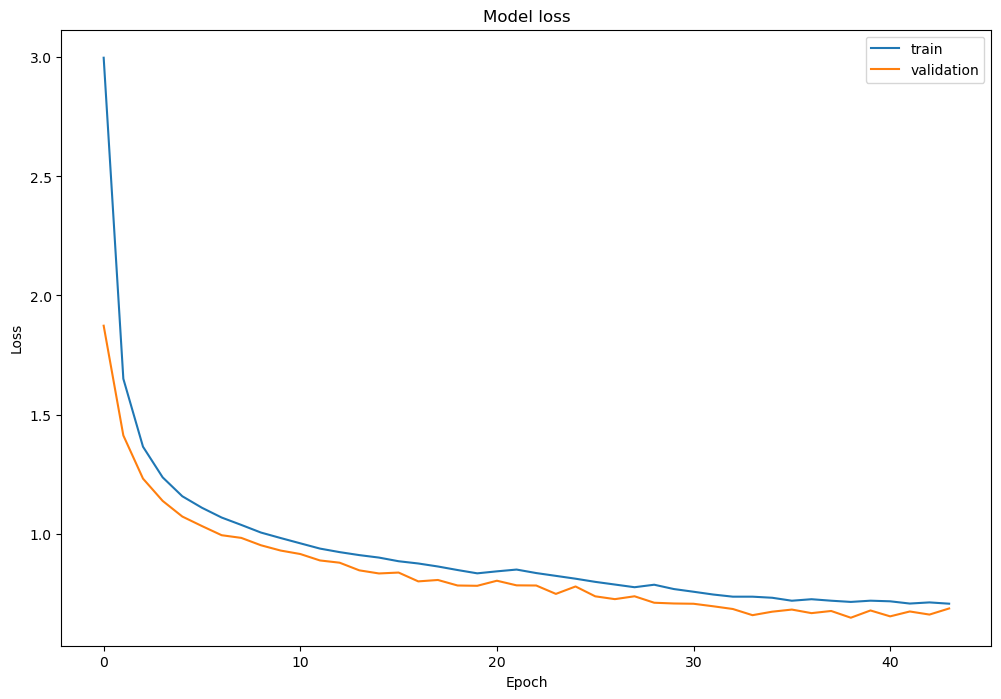

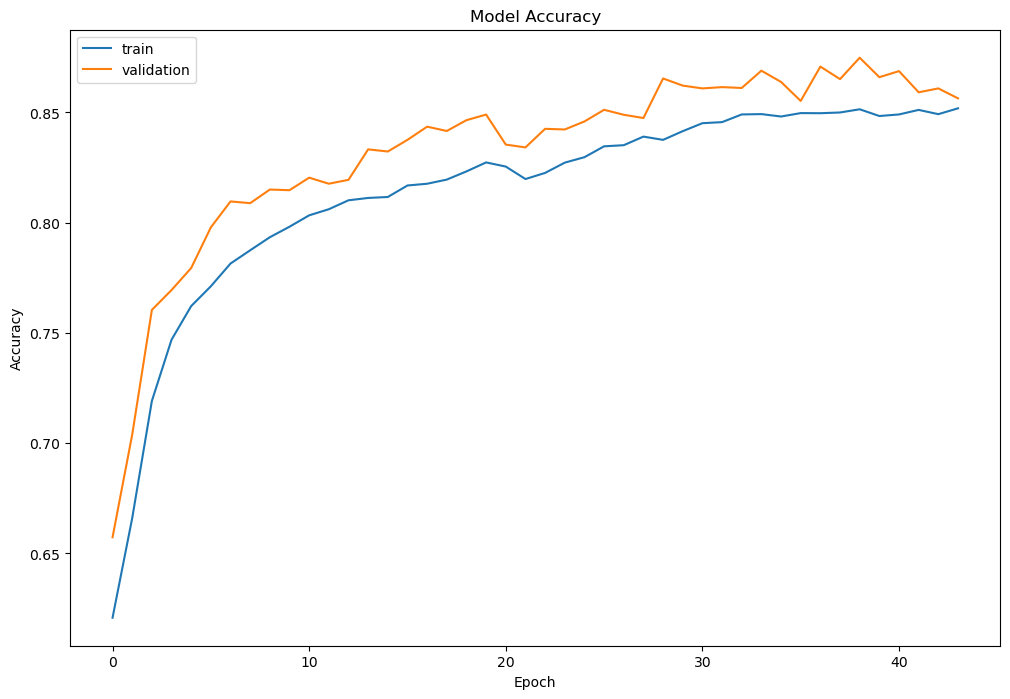

In [51]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

# Проба с дополнительными классами
* Работает чуть хуже: 

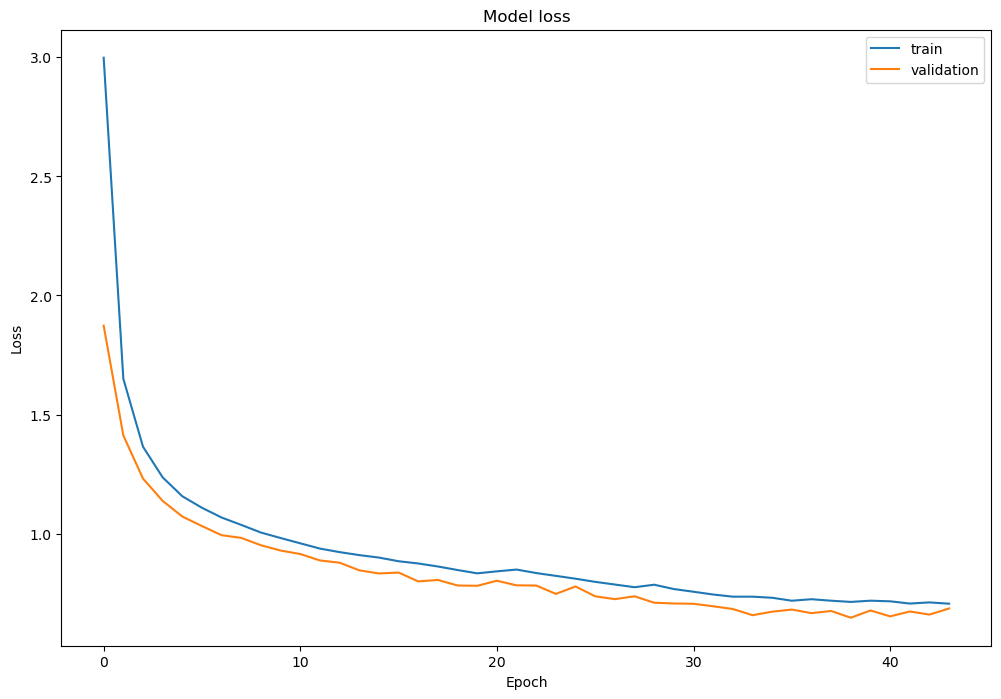
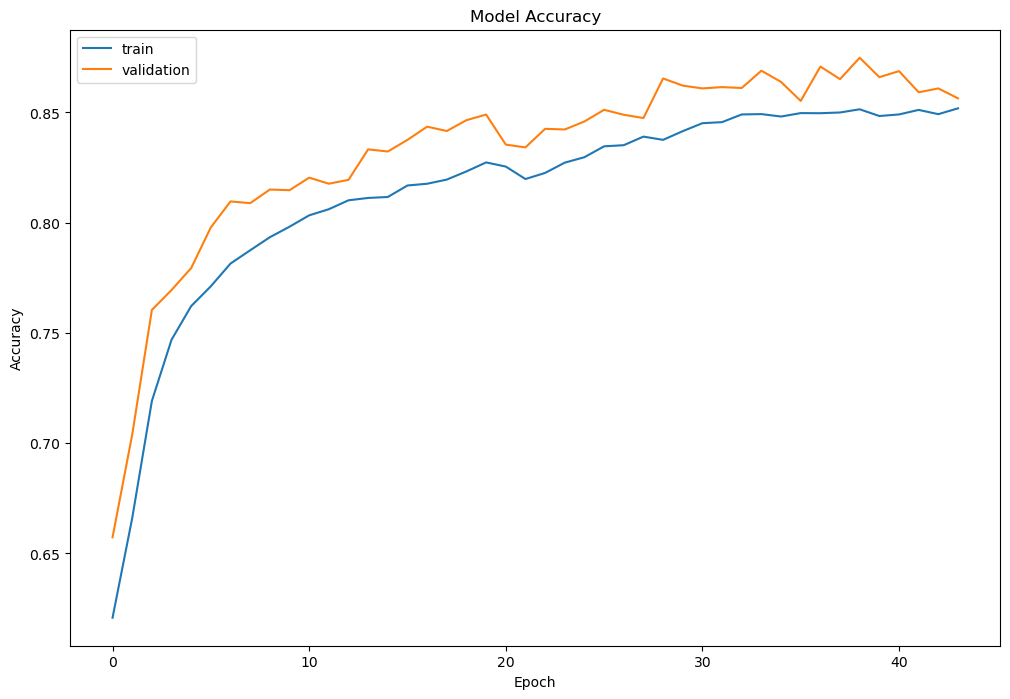

# Предикт на тестовых данных

In [64]:
# Оценка модели на тестовых данных
y_pred = model.predict(X_sequences_test)
y_pred_classes = np.argmax(y_pred, axis=1)

319/319 [==============================] - 0s 1ms/step


In [55]:
print(classification_report(y_sequences_test, y_pred_classes, target_names=GESTURES, zero_division=0))

                precision    recall  f1-score   support

     Neutral 0       0.92      0.96      0.94      6560
ThumbFingers 1       0.73      0.65      0.69       380
       Close 2       0.94      0.70      0.80       344
        Open 3       0.83      0.81      0.82       381
       Pinch 4       0.79      0.76      0.77       369
  Indication 5       0.88      0.82      0.85       369
  Wrist_Flex 6       0.86      0.69      0.76       356
Wrist_Extend 7       0.85      0.87      0.86       381

      accuracy                           0.90      9140
     macro avg       0.85      0.78      0.81      9140
  weighted avg       0.90      0.90      0.90      9140



# Эксперимент с добавлением весов классов (результат хуже)

In [ ]:
""" from sklearn.utils.class_weight import compute_class_weight

# Вычисление весов классов
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_combined), y=y_train_combined)
class_weights = dict(enumerate(class_weights))

# Построение модели с лучшими гиперпараметрами
class_model = create_lstm_model((timesteps, X_sequences_train.shape[2]), n_units, dropout_rate, learning_rate, use_bidirectional, use_gru)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
class_model.fit(X_sequences_train, y_sequences_train_encoded, validation_data=(X_sequences_test, y_sequences_test_encoded), epochs=100, batch_size=64, callbacks=[early_stopping], class_weight=class_weights, verbose=1)

# Оценка модели на тестовых данных
y_pred = class_model.predict(X_sequences_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_sequences_test_encoded, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=GESTURES, zero_division=0)) 

print(class_weights)"""

```py
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Пример использования Bidirectional LSTM и GRU
model = Sequential([
    Bidirectional(LSTM(32, return_sequences=True, input_shape=(timesteps, X_sequences_train.shape[2]), kernel_regularizer=l2(0.01))),
    Dropout(0.3),
    GRU(64, return_sequences=False, kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(y_sequences_train_encoded.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Обучение модели
history = model.fit(X_sequences_train, y_sequences_train_encoded, epochs=20, validation_split=0.2, batch_size=32, callbacks=[early_stopping], class_weight=class_weights)
```

~~~Epoch 1/20
872/872 [==============================] - 13s 7ms/step - loss: 2.3096 - accuracy: 0.1097 - val_loss: 2.0948 - val_accuracy: 0.0405
Epoch 2/20
872/872 [==============================] - 4s 5ms/step - loss: 2.0891 - accuracy: 0.0431 - val_loss: 2.0914 - val_accuracy: 0.0405
Epoch 3/20
872/872 [==============================] - 4s 5ms/step - loss: 2.0844 - accuracy: 0.0422 - val_loss: 2.0890 - val_accuracy: 0.0405
Epoch 4/20
872/872 [==============================] - 5s 5ms/step - loss: 2.0830 - accuracy: 0.0426 - val_loss: 2.0792 - val_accuracy: 0.0405
Epoch 5/20
872/872 [==============================] - 4s 5ms/step - loss: 2.0813 - accuracy: 0.0419 - val_loss: 2.0876 - val_accuracy: 0.0405
Epoch 6/20
872/872 [==============================] - 5s 5ms/step - loss: 2.0799 - accuracy: 0.0427 - val_loss: 2.0837 - val_accuracy: 0.0405
Epoch 7/20
872/872 [==============================] - 4s 5ms/step - loss: 2.0788 - accuracy: 0.0426 - val_loss: 2.0771 - val_accuracy: 0.0405
Epoch 8/20
872/872 [==============================] - 5s 5ms/step - loss: 2.0780 - accuracy: 0.0865 - val_loss: 2.0829 - val_accuracy: 0.0405
Epoch 9/20
872/872 [==============================] - 5s 5ms/step - loss: 2.0775 - accuracy: 0.0429 - val_loss: 2.0765 - val_accuracy: 0.0405
Epoch 10/20
872/872 [==============================] - 5s 5ms/step - loss: 2.0769 - accuracy: 0.0538 - val_loss: 2.0840 - val_accuracy: 0.0372
Epoch 11/20
872/872 [==============================] - 5s 5ms/step - loss: 2.0766 - accuracy: 0.0406 - val_loss: 2.0823 - val_accuracy: 0.0372
Epoch 12/20
872/872 [==============================] - 5s 5ms/step - loss: 2.0762 - accuracy: 0.0420 - val_loss: 2.0801 - val_accuracy: 0.0372
Epoch 13/20
...
Epoch 19/20
872/872 [==============================] - 4s 5ms/step - loss: 2.0751 - accuracy: 0.0671 - val_loss: 2.0808 - val_accuracy: 0.0372
Epoch 20/20
872/872 [==============================] - 5s 5ms/step - loss: 2.0751 - accuracy: 0.0435 - val_loss: 2.0739 - val_accuracy: 0.0372~~~

```py
from imblearn.over_sampling import SMOTE

# Применение SMOTE к тренировочным данным
smote = SMOTE(random_state=42)
X_sequences_train_resampled, y_sequences_train_resampled = smote.fit_resample(X_sequences_train.reshape((X_sequences_train.shape[0], -1)), y_sequences_train)
X_sequences_train_resampled = X_sequences_train_resampled.reshape((X_sequences_train_resampled.shape[0], timesteps, X_sequences_train.shape[2]))

# Преобразование меток в one-hot encoding
y_sequences_train_encoded_resampled = to_categorical(y_sequences_train_resampled, num_classes=8)

# Построение модели
model = Sequential([
    LSTM(64, input_shape=(timesteps, X_sequences_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(y_sequences_train_encoded_resampled.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Обучение модели
history = model.fit(X_sequences_train_resampled, y_sequences_train_encoded_resampled, epochs=10, validation_split=0.2, batch_size=64)
```

~~~Epoch 1/10
2453/2453 [==============================] - 19s 6ms/step - loss: 0.0932 - accuracy: 0.2961 - val_loss: 0.1431 - val_accuracy: 0.0000e+00
Epoch 2/10
2453/2453 [==============================] - 13s 5ms/step - loss: 0.0950 - accuracy: 0.2813 - val_loss: 0.1440 - val_accuracy: 0.0000e+00
Epoch 3/10
2453/2453 [==============================] - 14s 6ms/step - loss: 0.0950 - accuracy: 0.2821 - val_loss: 0.1428 - val_accuracy: 0.0000e+00
Epoch 4/10
2453/2453 [==============================] - 15s 6ms/step - loss: 0.0950 - accuracy: 0.2815 - val_loss: 0.1424 - val_accuracy: 0.0000e+00
Epoch 5/10
2453/2453 [==============================] - 14s 6ms/step - loss: 0.0949 - accuracy: 0.2821 - val_loss: 0.1444 - val_accuracy: 0.0000e+00
Epoch 6/10
2453/2453 [==============================] - 14s 6ms/step - loss: 0.0949 - accuracy: 0.2815 - val_loss: 0.1455 - val_accuracy: 0.0000e+00
Epoch 7/10
2453/2453 [==============================] - 14s 6ms/step - loss: 0.0949 - accuracy: 0.2824 - val_loss: 0.1440 - val_accuracy: 0.0000e+00
Epoch 8/10
2453/2453 [==============================] - 18s 7ms/step - loss: 0.0949 - accuracy: 0.2818 - val_loss: 0.1432 - val_accuracy: 0.0000e+00
Epoch 9/10
2453/2453 [==============================] - 15s 6ms/step - loss: 0.0949 - accuracy: 0.2826 - val_loss: 0.1444 - val_accuracy: 0.0000e+00
Epoch 10/10
2453/2453 [==============================] - 13s 5ms/step - loss: 0.0949 - accuracy: 0.2824 - val_loss: 0.1445 - val_accuracy: 0.0000e+00~~~

```py
from imblearn.under_sampling import RandomUnderSampler

# Применение RandomUnderSampler к тренировочным данным
rus = RandomUnderSampler(random_state=42)
X_sequences_train_resampled, y_sequences_train_resampled = rus.fit_resample(X_sequences_train.reshape((X_sequences_train.shape[0], -1)), y_sequences_train)
X_sequences_train_resampled = X_sequences_train_resampled.reshape((X_sequences_train_resampled.shape[0], timesteps, X_sequences_train.shape[2]))

# Преобразование меток в one-hot encoding
y_sequences_train_encoded_resampled = to_categorical(y_sequences_train_resampled, num_classes=8)

# Построение модели
model = Sequential([
    LSTM(64, input_shape=(timesteps, X_sequences_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(y_sequences_train_encoded_resampled.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(X_sequences_train_resampled, y_sequences_train_encoded_resampled, epochs=100, validation_split=0.2, batch_size=32) 
```

~~~Epoch 1/100
276/276 [==============================] - 8s 11ms/step - loss: 1.6976 - accuracy: 0.3002 - val_loss: 5.0512 - val_accuracy: 0.0000e+00
Epoch 2/100
276/276 [==============================] - 1s 5ms/step - loss: 1.5809 - accuracy: 0.3450 - val_loss: 4.9776 - val_accuracy: 0.0368
Epoch 3/100
276/276 [==============================] - 1s 5ms/step - loss: 1.5467 - accuracy: 0.3530 - val_loss: 6.0224 - val_accuracy: 0.0458
Epoch 4/100
276/276 [==============================] - 1s 4ms/step - loss: 1.5268 - accuracy: 0.3658 - val_loss: 6.0431 - val_accuracy: 0.0526
Epoch 5/100
276/276 [==============================] - 1s 5ms/step - loss: 1.5164 - accuracy: 0.3713 - val_loss: 5.9106 - val_accuracy: 0.0522
Epoch 6/100
276/276 [==============================] - 1s 5ms/step - loss: 1.5062 - accuracy: 0.3783 - val_loss: 5.9391 - val_accuracy: 0.0549
Epoch 7/100
276/276 [==============================] - 1s 5ms/step - loss: 1.5004 - accuracy: 0.3748 - val_loss: 6.3303 - val_accuracy: 0.0544
Epoch 8/100
276/276 [==============================] - 1s 5ms/step - loss: 1.4950 - accuracy: 0.3849 - val_loss: 6.8694 - val_accuracy: 0.0531
Epoch 9/100
276/276 [==============================] - 1s 4ms/step - loss: 1.4897 - accuracy: 0.3865 - val_loss: 6.8521 - val_accuracy: 0.0708
Epoch 10/100
276/276 [==============================] - 1s 4ms/step - loss: 1.4896 - accuracy: 0.3900 - val_loss: 7.2825 - val_accuracy: 0.0544
Epoch 11/100
276/276 [==============================] - 1s 5ms/step - loss: 1.4805 - accuracy: 0.3925 - val_loss: 7.1092 - val_accuracy: 0.0622
Epoch 12/100
276/276 [==============================] - 1s 5ms/step - loss: 1.4760 - accuracy: 0.3971 - val_loss: 6.7145 - val_accuracy: 0.0549
Epoch 13/100
...
Epoch 99/100
276/276 [==============================] - 1s 4ms/step - loss: 1.4119 - accuracy: 0.4127 - val_loss: 14.2999 - val_accuracy: 0.0858
Epoch 100/100
276/276 [==============================] - 1s 4ms/step - loss: 1.4192 - accuracy: 0.4117 - val_loss: 15.1316 - val_accuracy: 0.0808~~~

# Инференс модели на 1 файле (использовалось для теста инференса) 

In [245]:
real_mont = '2024-12-15_15-06-56.emg8'
data = pd.read_csv(DATA_DIR + '/' + real_mont, sep=' ')
display(data)

ts    td        omg0        omg1       omg2        omg3  \
0      847816.0  40.0  14863454.0  11664500.0  6386690.0  12768347.0   
1      847856.0  40.0  14864301.0  11667889.0  6389224.0  12780844.0   
2      847896.0  40.0  14861518.0  11654628.0  6386981.0  12769693.0   
3      847936.0  40.0  14861539.0  11656781.0  6393848.0  12770668.0   
4      847976.0  40.0  14854197.0  11651074.0  6391946.0  12753164.0   
...         ...   ...         ...         ...        ...         ...   
5770  1078616.0  40.0  14828592.0  10514343.0  6692328.0  13844787.0   
5771  1078656.0  40.0  14825610.0  10546533.0  6702213.0  13824561.0   
5772  1078696.0  40.0  14819539.0  10497828.0  6678880.0  13751795.0   
5773  1078736.0  40.0  14812240.0  10485830.0  6682820.0  13767010.0   
5774  1078776.0  40.0  14800749.0  10471063.0  6688090.0  13812255.0   

            omg4       omg5       omg6        omg7  ...  prb4  prb5  prb6  \
0     11407687.0  7328927.0  9903981.0  14579164.0  ...  0.12  0.12  0.12   
1     11403690.0  7329353.0  9906895.0  14576251.0  ...  0.12  0.12  0.12   
2     11398766.0  7324444.0  9908971.0  14572823.0  ...  0.12  0.12  0.12   
3     11407216.0  7330696.0  9923381.0  14584782.0  ...  0.12  0.12  0.12   
4     11410467.0  7338103.0  9933492.0  14604138.0  ...  0.12  0.12  0.12   
...          ...        ...        ...         ...  ...   ...   ...   ...   
5770  10620046.0  7372187.0  8896535.0  12543627.0  ...  0.12  0.12  0.12   
5771  10628803.0  7385653.0  8923208.0  12575168.0  ...  0.12  0.12  0.12   
5772  10645753.0  7371504.0  8942271.0  12605936.0  ...  0.12  0.12  0.12   
5773  10637828.0  7386287.0  8929571.0  12613763.0  ...  0.12  0.12  0.12   
5774  10637240.0  7396778.0  8930379.0  12634517.0  ...  0.12  0.12  0.12   

      prb7  argmax  denoize  prot     state  id     now  
0     0.12     0.0      0.0     0  Baseline  -1    0.00  
1     0.12     0.0      0.0     0  Baseline  -1    0.04  
2     0.12     0.0      0.0     0  Baseline  -1    0.08  
3     0.12     0.0      0.0     0  Baseline  -1    0.12  
4     0.12     0.0      0.0     0  Baseline  -1    0.16  
...    ...     ...      ...   ...       ...  ..     ...  
5770  0.12     0.0      0.0   116    Finish  -1  230.80  
5771  0.12     0.0      0.0   116    Finish  -1  230.84  
5772  0.12     0.0      0.0   116    Finish  -1  230.88  
5773  0.12     0.0      0.0   116    Finish  -1  230.92  
5774  0.12     0.0      0.0   116    Finish  -1  230.96  

[5775 rows x 43 columns]

In [238]:
def preprocessing(buffer_df, omg_sample, timesteps):
    # Проверка количества признаков
    if omg_sample.shape[0] != 16:
        raise ValueError(f"Expected 16 features, but got {omg_sample.shape[0]}")

    # Нормализация данных
    omg_sample_norm = scaler.transform(omg_sample.values.reshape(1, -1))

    # Добавление нормализованной строки в буфер
    buffer_df.loc[len(buffer_df)] = omg_sample_norm.flatten()

    # Проверка, достаточно ли данных для создания последовательности
    if len(buffer_df) >= timesteps:
        # Создание последовательности
        X_seq = buffer_df.values[-timesteps:]
        X_seq = X_seq.reshape((1, timesteps, X_seq.shape[1]))
        return X_seq, buffer_df
    else:
        return None, buffer_df

# Функция для выполнения инференса (предсказания)
def inference(model, X_seq):
    y_pred_prob = model.predict(X_seq)
    # y_pred = np.argmax(y_pred_prob, axis=1)[0]  # Получаем скалярное значение
    return y_pred_prob

def postprocessing(y_pred_prob):
    y_pred = np.argmax(y_pred_prob, axis=1)[0]  # Получаем скалярное значение
    return y_pred

In [240]:
df_sim = data[OMG_CH].iloc[3300:]
print(df_sim.shape)

(2475, 16)


In [253]:
import time
import pandas as pd

# Основной цикл для обработки данных в реальном времени
TIMEOUT = 0.040
DEBUG = True

i = 0
ts_old = time.time()
ts_diff = 0
comp_durations = np.empty(0)

y_previous = None
y_dct = {
    'omg_sample': [],
    'sample_preprocessed': [],
    'y_predicted': [],
    'y_postprocessed': [],
}

# Инициализация буфера
buffer_df = pd.DataFrame(columns=[f'omg{i}' for i in range(16)])

while True:
    # [Data reading]
    ts_start = time.time()

    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        # td_ts, omg_sample, _ = np.array_split(sample, [2, 2 + 16])
        omg_sample = pd.Series(sample, name='omg_sample')  # Преобразование в Series

    except Exception as e:
        print(e)

    # [/Data Reading]

    # [Data preprocessing]
    X_seq, buffer_df = preprocessing(buffer_df, omg_sample, timesteps=3)  # Используем timesteps=3 для примера
    if X_seq is not None:
        sample_preprocessed = X_seq
    else:
        continue
    # [/Data preprocessing]

    # [Inference]
    y_predicted = inference(model, sample_preprocessed)
    # [/Inference]

    # [Inference Postprocessing]
    y_postprocessed = postprocessing(y_predicted)
    # [/Inference Postprocessing]

    # [Commands composition]
    # NO COMMANDS FORMING IN SIMULATION
    # [/Commands composition]

    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]

    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    # [/Data logging]

    y_previous = y_postprocessed

    if DEBUG:
        # Sanity check: Sizes of SAMPLE=65, OMG=16
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}', end='             \r')

    ts_diff = time.time() - ts_start
    # assert(ts_diff < TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    comp_duration = ts_diff
    comp_durations = np.append(comp_durations, comp_duration)
    i += 1

1/1 [==============================] - 0s 23ms/step


In [ ]:
print(f"Максимальное время: {np.round(comp_durations.max() * 1000, 2)} мс")
print(f"Среднее время: {np.round(comp_durations.mean() * 1000, 2)} мс")